In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 21 19:45:13 2022

@author: hp
"""
import numpy as np
import tensorly as tl
from utils_TC import gen_data_potential_Y_observed, \
    TC_MSM, sw_estimation_calibration,\
    TensorCompletionCovariateProjected, MC_GradientDescent,\
        plot3D_tensor
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import tensorly.decomposition

params = {'axes.labelsize': 'x-large',
         'axes.titlesize': 32,
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
# number of subjects
N = 100
# number of time points
T = 10
# number of past treatment regime 
k = 5
# number of baseline covariates
d0 = 20
# complex outcomes and less correlated treatments 
case = 3
# random seed for reproducibility
seed = 1

In [7]:
# generate the observed potential outcomes
Y_obs, XX, A, Omega, X0, Y_star = gen_data_potential_Y_observed(seed = seed, N = N, T = T,
                              d0 = d0, k = k, case = case)

# W = sw_estimation_univariate(Aobs = A, X = X, k = k, pool = True)
W = sw_estimation_calibration(Yobs = Y_obs, Aobs = A, XX = XX, X0 = None,
                              Omega = Omega, k = 2)
# W = W[:,:, np.newaxis] # algin with the dimension

W = np.repeat(W[:,:, np.newaxis], 2**k, axis = 2) * Omega


# Legendre polynomial
# from sklearn.preprocessing import normalize
def poly(n, x):
    return x**n
def P(n, x): 
    if(n == 0):
        return 1 # P0 = 1
    elif(n == 1):
        return x # P1 = x
    else:
        return (((2 * n)-1)*x * P(n-1, x)-(n-1)*P(n-2, x))/float(n)
# construct 10th order Legendre polynomial  basis function as Phi_X
to_stack = []
to_stack.append(
   np.ones(shape=(N, 1)))
for deg in range(1, (6+1)):
    to_stack.append(
        np.apply_along_axis(lambda x: P(deg, x), 1, X0)
        )
# change for different number of basis
Phi_X = np.hstack(to_stack)
Phi_X_orth, _ = np.linalg.qr(Phi_X)

## Marginal Structural Model

In [4]:
Y_hat_MSM, _ = TC_MSM(Aobs = A, Yobs = np.apply_along_axis(sum, 2, Y_obs),
        X0 = Phi_X, X = np.apply_along_axis(sum, 2, XX),
        wts = np.apply_along_axis(sum, 2, W))

## Unfolded Matrix Completion ([Fan  et. al. 2016](https://projecteuclid.org/journals/annals-of-statistics/volume-44/issue-1/Projected-principal-component-analysis-in-factor-models/10.1214/15-AOS1364.full))

In [8]:
Y_MC_hat_unfold = MC_GradientDescent(Y_t = tl.unfold(Y_obs, 0),
                              W_t = tl.unfold(W, 0),
                              Omega_t = tl.unfold(Omega, 0),  
                              X0 = Phi_X_orth,
                              rank = 8,
                              step_size = 1/np.linalg.norm(Y_obs)*1e-4, 
                              niters = 5000, tol = 1e-8)
Y_MC_hat_fold = tl.fold(Y_MC_hat_unfold, 0, Y_obs.shape)

(MC-Gradient)0-th iteration: loss 4002.63 and update 0.33
(MC-Gradient)1000-th iteration: loss 62.18 and update 0.0
(MC-Gradient)2000-th iteration: loss 36.18 and update 0.0
(MC-Gradient)3000-th iteration: loss 27.07 and update 0.0
(MC-Gradient)4000-th iteration: loss 22.92 and update 0.0


## Tucker Tensor Completion

In [13]:
TC_Tucker = TensorCompletionCovariateProjected(Y = Y_obs, X0 = None, Omega = Omega,
                                    W_tensor = W, 
                                    stepsize = 1/(np.linalg.norm(Y_obs)) * 1e-5, #1/(np.linalg.norm(Phi_X)) * 1e-5, *(default)
                                    niters = 5000, tol = 1e-8,
                                    r1_list = [6], r2_list = [2], r3_list = [8])
Y_hat_Tucker = TC_Tucker.SequentialTuning()

(Tucker): 0th iteration with loss: 23508.95 and update 0.51
(Tucker): 1000th iteration with loss: 793.92 and update 0.0
(Tucker): 2000th iteration with loss: 383.08 and update 0.0
(Tucker): 3000th iteration with loss: 278.56 and update 0.0
(Tucker): 4000th iteration with loss: 240.42 and update 0.0


## Covariate-assisted Tucker Tensor Completion

In [16]:
TC_CoTucker = TensorCompletionCovariateProjected(Y = Y_obs, X0 = Phi_X_orth, Omega = Omega,
                                    W_tensor = W, 
                                    stepsize = 1/(np.linalg.norm(Y_obs)) * 1e-5, # None: motivated by nablu^2 L
                                    niters = 5000, tol = 1e-8,
                                    r1_list = [6], r2_list = [2], r3_list = [8])
Y_hat_CoTucker = TC_CoTucker.SequentialTuning()

(Co-Tucker): 0th iteration with loss: 23508.95 and update 0.51
(Co-Tucker): 1000th iteration with loss: 793.92 and update 0.0
(Co-Tucker): 2000th iteration with loss: 383.08 and update 0.0
(Co-Tucker): 3000th iteration with loss: 278.56 and update 0.0
(Co-Tucker): 4000th iteration with loss: 240.42 and update 0.0


## Visualization

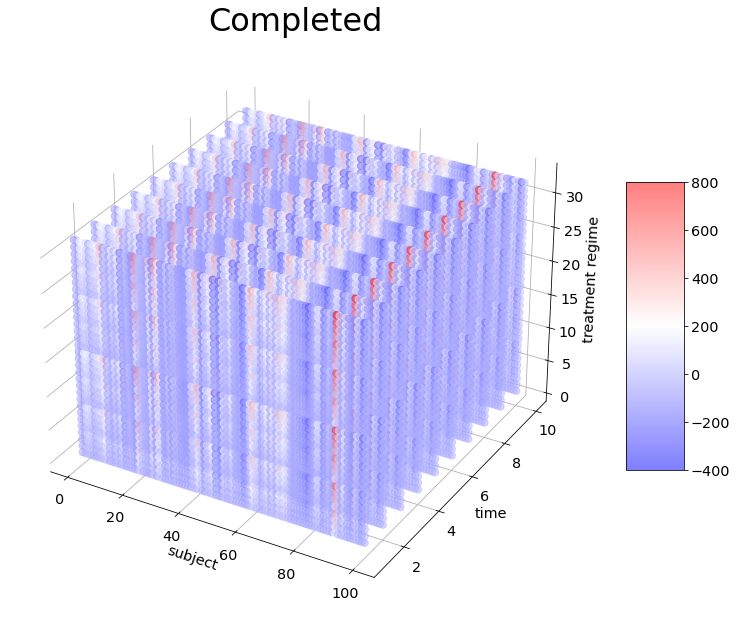

In [18]:
# completed
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
p1 = plot3D_tensor(Y_star, N = N, T = T, k = k, ax = ax,
                   title_main = 'Completed')
fig.colorbar(p1, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('true_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()

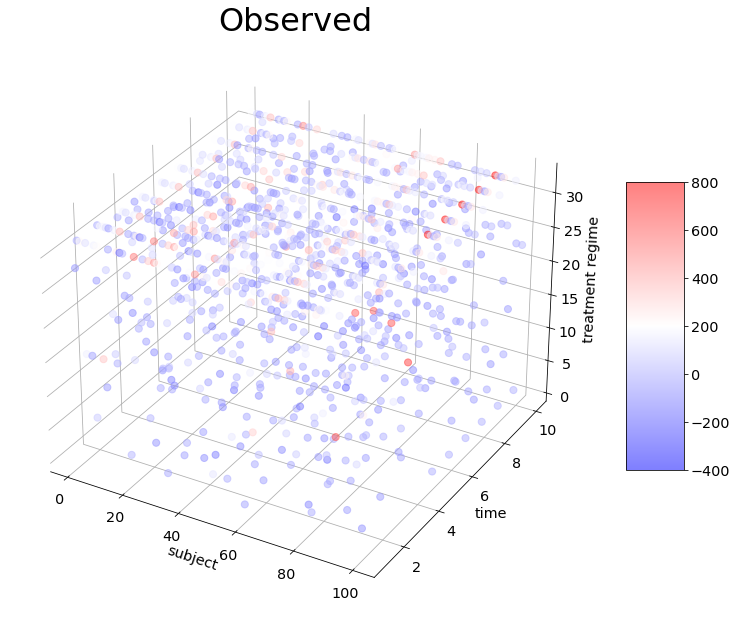

In [19]:
# observed
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
Y_obs_plot = Y_star.copy()
Y_obs_plot[Omega == 0] = np.nan
p2 = plot3D_tensor(Y_obs_plot, N = N, T = T, k = k, ax = ax,
                   title_main = 'Observed')
fig.colorbar(p2, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('observed_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()

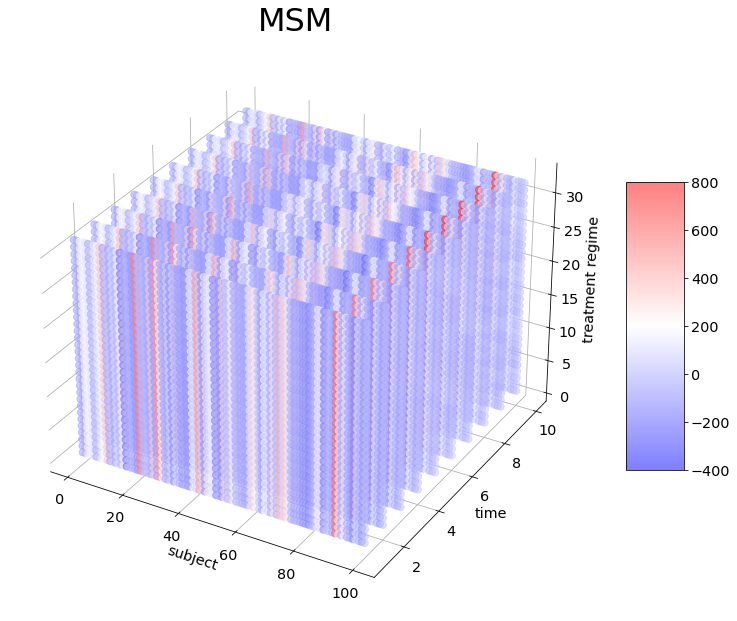

MSM error:  0.8046474811343614


In [20]:
# MSM
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
p3 = plot3D_tensor(Y_hat_MSM, N = N, T = T, k = k, ax = ax,
                   title_main = 'MSM')
fig.colorbar(p3, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('MSM_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()
print('MSM error: ', np.linalg.norm(Y_star- Y_hat_MSM)/np.linalg.norm(Y_star))

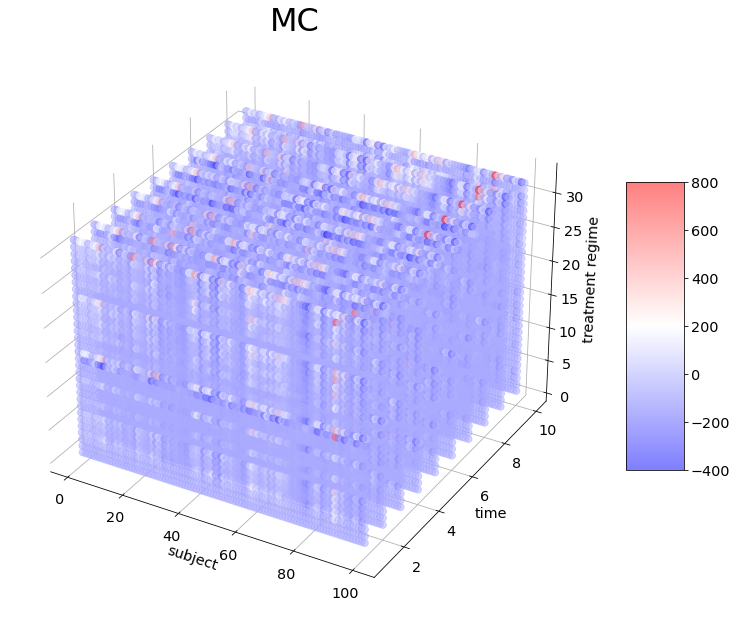

Matrix Completion error:  0.7841148971146386


In [21]:
# covariate-assisted matrix completion
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
p4 = plot3D_tensor(Y_MC_hat_fold, N = N, T = T, k = k, ax = ax,
                   title_main = 'MC')
fig.colorbar(p4, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('MC_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()
print('Matrix Completion error: ', np.linalg.norm(Y_star- Y_MC_hat_fold)/np.linalg.norm(Y_star))

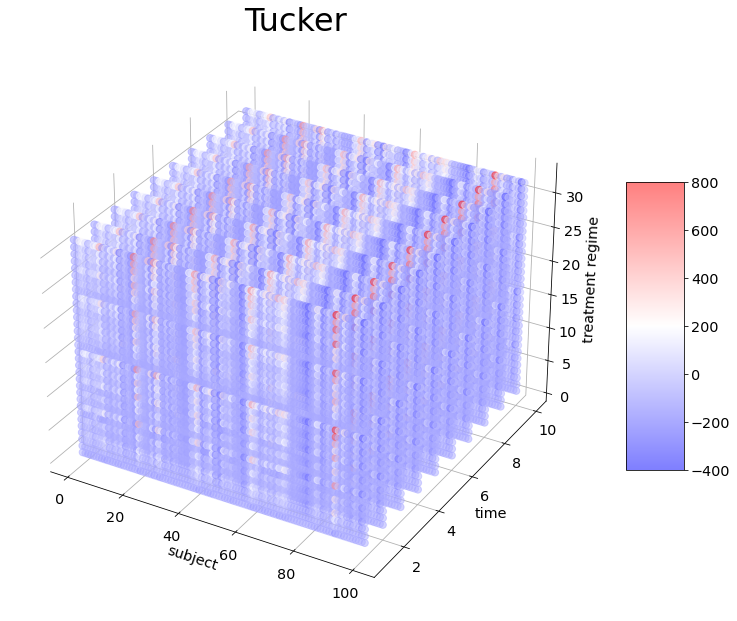

Tensor Completion error:  0.3092013931032055


In [22]:
# vanilla tensor completion
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
p6 = plot3D_tensor(Y_hat_Tucker, N = N, T = T, k = k, ax = ax,
                   title_main = 'Tucker')
fig.colorbar(p6, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('Tucker_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()
print('Tensor Completion error: ', np.linalg.norm(Y_star- Y_hat_Tucker)/np.linalg.norm(Y_star))

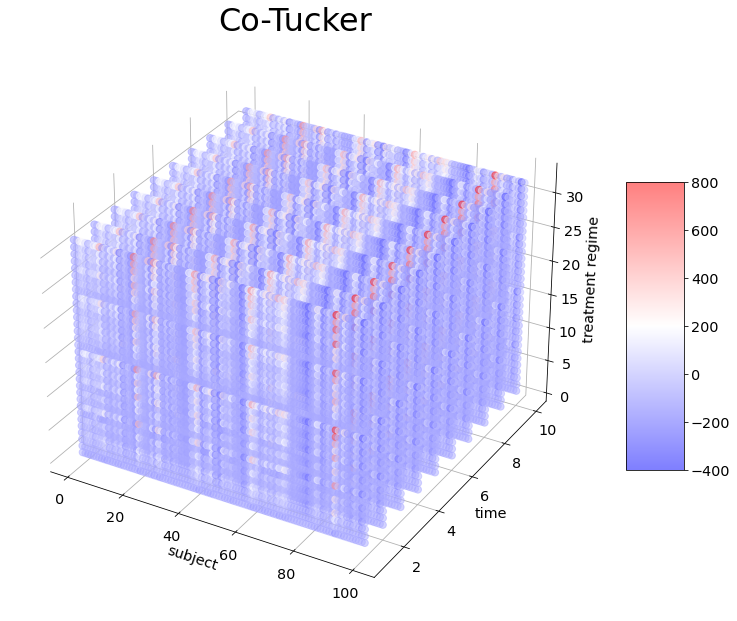

Covariate-assisted Tensor Completion error:  0.30920139308145017


In [23]:
# covariate-assisted tensor completion
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection = '3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
p7 = plot3D_tensor(Y_hat_CoTucker, N = N, T = T, k = k, ax = ax,
                   title_main = 'Co-Tucker')
fig.colorbar(p7, ax = ax, shrink = 0.5, aspect = 5)
# plt.savefig('CO_Tucker_case6_N100_T10_example.pdf', savefig = 'tight')
plt.show()
print('Covariate-assisted Tensor Completion error: ', np.linalg.norm(Y_star- Y_hat_CoTucker)/np.linalg.norm(Y_star))